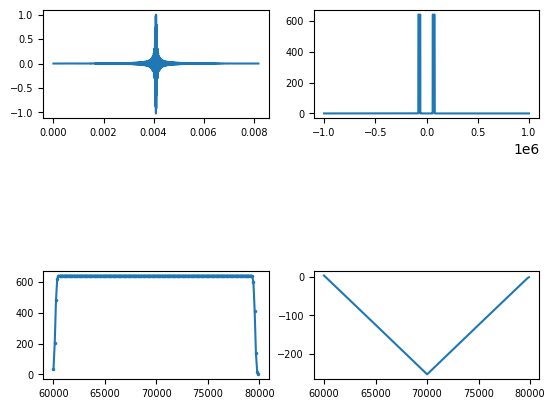

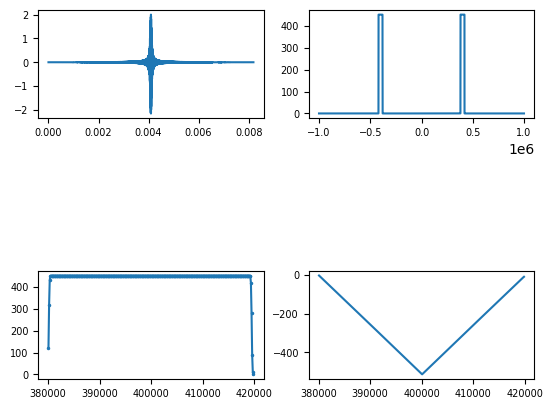

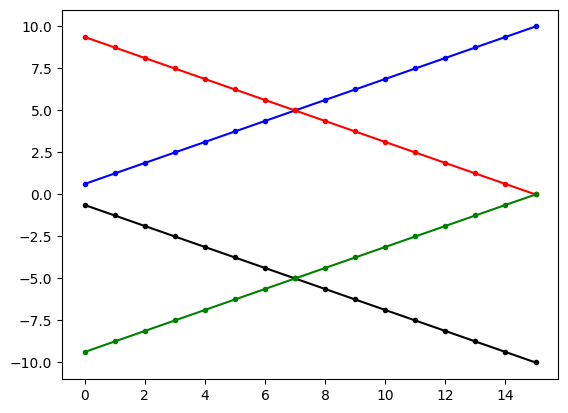

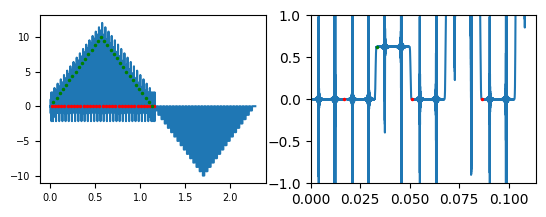

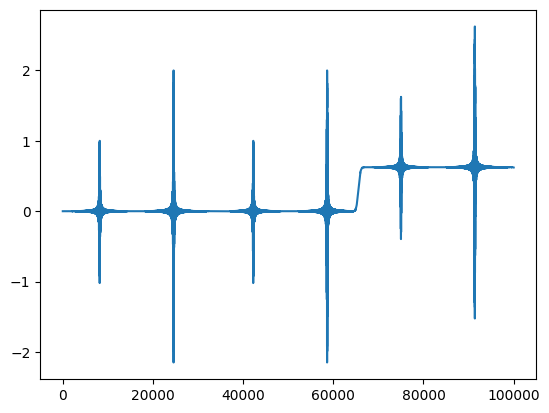

In [2]:
import numpy as np
from scipy.special import erf
import matplotlib.pyplot as plt

#global DAQ_platform_cond, BE_parm_vec_1, assembly_parm_vec, BE_parm_vec_2,SS_parm_vec, chirp_dir_cond, plot_cond_vec
#global code_section

#code section - checking for duplicates, building BEPS waveform, analying data
# DAQ_platform_cond
#BE_parm_vec_1 - ( BE_wave_type_1(0), BE_w_center_1(1),BE_w_width_1(2),BE_amp_1(3),BE_smoothing_1 (4),BE_phase_var_1(5),BE_window_adj_1 (6),BE_ppw_1(7),BE_rep_1(8))
#BE_parm_vec_2 - ( BE_wave_type_2(0), BE_w_center_2(1),BE_w_width_2(2),BE_amp_2(3),BE_smoothing_2 (4),BE_phase_var_2(5),BE_window_adj_2 (6),BE_ppw_2(7),BE_rep_2(8))
#assembly_parm_vec -  num_band_ring(0), par_ser_ring(1), meas_high_ring(2)
#SS_parm_vec - (SS_mode_ring [0], SS_max_offset_amp[1], SS_num_loops[2],SS_read_voltage[3], SS_start_V [4],SS_start_loop_amp [5], SS_final_loop_amp[6],SS_steps_per_cycle[7],SS_RW_ratio[8],SS_set_pulse_amp[9],SS_set_pulse_t[10],SS_smoothing[11],SS_step_t_req[12])
#bin_ind = lenght of bins_per_band
#chirp_dir_cond -(non-flip(0), flip(1))
#plot_cond_vec = 1

code_section = 1
DAQ_platform_cond = 0
BE_parm_vec_1 = [2,70000, 20000, 1,150,0.01,-0.11, 14, 0]
BE_parm_vec_2 = [2,400000, 40000, 2,150,0.01,-0.15, 14, 0]
assembly_parm_vec = [1,1,1,1]
SS_parm_vec = [0, 10,1,0,0,6,16,64,1,0,0,2E-6,0.01]
chirp_dir_cond = 0
plot_cond_vec = [1,1,1,0,1,1,1,1,0,1,0,0]
#bin_ind = lenght of bins_per_band

import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf


def build_SS(assembly_parm_vec, BE_parm_vec, SS_parm_vec):
  num_band_ring = assembly_parm_vec[0]
  par_ser_ring = assembly_parm_vec[1]
  meas_high_ring = assembly_parm_vec[2]
  BE_ppw = 2 ** BE_parm_vec[7]

  SS_mode_ring = SS_parm_vec[0]
  SS_max_offset_amp = SS_parm_vec[1]
  SS_num_loops = SS_parm_vec[2]
  SS_read_voltage = SS_parm_vec[3]
  SS_start_V = SS_parm_vec[4]
  SS_start_loop_amp = SS_parm_vec[5]
  SS_final_loop_amp = SS_parm_vec[6]
  SS_steps_per_cycle = SS_parm_vec[7]
  SS_RW_ratio = SS_parm_vec[8]
  SS_set_pulse_amp = SS_parm_vec[9]
  SS_set_pulse_t = SS_parm_vec[10]
  SS_smoothing = SS_parm_vec[11]
  SS_step_t_req = SS_parm_vec[12]


  n_read_final = BE_ppw  # points per read step actual
  if num_band_ring == 1:  # excite two bands
      if par_ser_ring == 1:  # excite them in series
          n_read_final = 2 * BE_ppw  # then double the width

  AO_rate, SS_step_t = determine_AO_rate(BE_ppw, SS_step_t_req)
  AO_length = AO_rate * SS_step_t

  n_read = 256  # points per read reduced in order to speed up calculation

  SS_smooth = AO_rate * SS_smoothing  # smoothing factor
  n_trans = round(SS_smooth * 5)
  # read_delay = 3; %ensures that the reading starts(stops) after(before) smoothing

  n_pfm = n_read_final  # AO_rate*SS_step_t*2;
  n_setpulse = AO_rate * SS_set_pulse_t

  if meas_high_ring == 0:
      n_write = int(n_read / SS_RW_ratio)  # points per write
  if meas_high_ring == 1:
      n_write = n_read

  # Build standard SSPFM waveform
  if SS_mode_ring == 0:

    n_write = n_write + n_trans
    n_cycle = (n_read + n_trans + n_write) * SS_steps_per_cycle  # points per cycle
    interp_factor = n_read_final / n_read

    n_step = n_write + n_trans + n_read  # data points per steps
    n_write_vec = np.arange(n_read, n_cycle // 4, n_step)  # vector indices when writing starts
    n_read_vec = n_write_vec + n_write  # vector of indices when writing stops

    dc_amp_vec_1 = np.arange(SS_max_offset_amp / (SS_steps_per_cycle / 4), SS_max_offset_amp + 1e-10,
                              SS_max_offset_amp / (SS_steps_per_cycle / 4))  # vector of offset values for first quarter wave
    dc_amp_vec_2 = np.arange( SS_max_offset_amp -(SS_max_offset_amp)/(SS_steps_per_cycle/4), -(SS_max_offset_amp)/(SS_steps_per_cycle/4), -(SS_max_offset_amp)/(SS_steps_per_cycle/4)) # vector of offset values for second quarter wave
    dc_amp_vec_3 = -dc_amp_vec_1
    dc_amp_vec_4 = -dc_amp_vec_2
    dc_amp_vec_1 = dc_amp_vec_1 - SS_read_voltage
    dc_amp_vec_2 = dc_amp_vec_2 - SS_read_voltage
    dc_amp_vec_3 = dc_amp_vec_3 - SS_read_voltage
    dc_amp_vec_4 = dc_amp_vec_4 - SS_read_voltage

    plt.figure(55)
    plt.clf()
    plt.plot(dc_amp_vec_1, 'b.-')
    plt.plot(dc_amp_vec_2, 'r.-')
    plt.plot(dc_amp_vec_3, 'k.-')
    plt.plot(dc_amp_vec_4, 'g.-')

    # build quarter waves
    n_sub = np.arange(1, n_cycle // 4 )
    y1 = np.zeros_like(n_sub)
    y2 = np.zeros_like(n_sub)
    y3 = np.zeros_like(n_sub)
    y4 = np.zeros_like(n_sub)
  
    for step_count in range((SS_steps_per_cycle//4)):
      yk1 = dc_amp_vec_1[step_count] * 0.5 * (
          erf((n_sub - n_write_vec[step_count]) / SS_smooth) - erf((n_sub - n_read_vec[step_count]) / SS_smooth))
      
      yk2 = dc_amp_vec_2[step_count] * 0.5 * (
          erf((n_sub - n_write_vec[step_count]) / SS_smooth) - erf((n_sub - n_read_vec[step_count]) / SS_smooth))
      
      yk3 = dc_amp_vec_3[step_count] * 0.5 * (
          erf((n_sub - n_write_vec[step_count]) / SS_smooth) - erf((n_sub - n_read_vec[step_count]) / SS_smooth))
      yk4 = dc_amp_vec_4[step_count] * 0.5 * (
          erf((n_sub - n_write_vec[step_count]) / SS_smooth) - erf((n_sub - n_read_vec[step_count]) / SS_smooth))

      y1 = y1 + yk1
      y2 = y2 + yk2
      y3 = y3 + yk3
      y4 = y4 + yk4

    # combine quarter waves to build full cycle
    n = np.arange(n_cycle-4 ) #fix
    y = np.concatenate((y1, y2, y3, y4))
    dc_amp_vec_single = np.concatenate(
        (dc_amp_vec_1, dc_amp_vec_2, dc_amp_vec_3, dc_amp_vec_4))
    # interpolate wave and read/write indices to achieve desired number of points per read step
    ni = np.arange(1, int(n_cycle * interp_factor) + 1) / interp_factor
    yi = np.interp(ni, n, y)  # offset output wave

    ni *= interp_factor
    n_write_vec = np.concatenate(
        (np.arange(n_read, n_cycle // 2, n_step),
          n_cycle // 2 + np.arange(n_read, n_cycle // 2 - n_read - 1, -n_step)))
    n_read_vec = np.concatenate(([1 / interp_factor], n_write_vec + n_write))
    ni_read_vec = n_read_vec * interp_factor  # vector of indices for reading
    ni_write_vec = n_write_vec * interp_factor  # vector of indices for writing
    ni_read_vec = ni_read_vec[:-1]
    ni_write_vec = ni_write_vec[:-1]

    # repeat full cycle
    yi0 = yi.copy()
    ni_write_vec0 = ni_write_vec.copy()
    ni_read_vec0 = ni_read_vec.copy()
    dc_amp_vec_full = dc_amp_vec_single.copy()

    for k in range(SS_num_loops - 1):
      yi = np.concatenate((yi, yi0))
      ly = len(yi) - len(yi0)
      final_read = ni_read_vec[-1]
      ni_write_vec = np.concatenate(
          (ni_write_vec, [final_read + n_read * interp_factor], ni_write_vec0 + ly))
      ni_read_vec = np.concatenate((ni_read_vec, ni_read_vec0 + ly))
      dc_amp_vec_full = np.concatenate((dc_amp_vec_full, dc_amp_vec_single))
    
    n_sp = np.arange(1, n_setpulse + 2 * n_trans + 1)
    y_sp = 0.5 * SS_set_pulse_amp * (erf((n_sp - n_trans * interp_factor) / (SS_smooth * interp_factor))
                                    - erf((n_sp - n_setpulse + n_trans * interp_factor) / (SS_smooth * interp_factor)))

    # Add PFM read and setpulse
    ni = np.arange(1, len(ni) * SS_num_loops + n_pfm + n_setpulse + 1)
    yi = np.concatenate((np.zeros(n_pfm), y_sp, yi))
    ni_read_vec = ni_read_vec + n_pfm + n_setpulse
    ni_write_vec = ni_write_vec + n_pfm + n_setpulse
    SS_read_vec = np.round(ni_read_vec + np.round(n_trans * interp_factor / 2))
    SS_write_vec = np.round(ni_write_vec + np.round(n_trans * interp_factor / 2))
    SS_write_vec = np.concatenate((SS_write_vec, [SS_write_vec[-1] + np.round(n_step * interp_factor)]))
    SS_read_vec[0] = np.round(ni_read_vec[0]) - interp_factor * n_trans / 2
    SS_wave = yi + SS_read_voltage
    dc_amp_vec_full = dc_amp_vec_full + SS_read_voltage
    SS_wave_nan = np.where(np.isnan(SS_wave))[0]
    SS_wave[SS_wave_nan] = 0
    SS_parm_out = np.arange(2, 12)

    # Build FORC waveform
    if SS_mode_ring == 1:
      SS_steps_per_cycle = 2 * SS_steps_per_cycle
      n_write = n_write + n_trans
      n_cycle = (n_read + n_trans + n_write) * SS_steps_per_cycle  # points per cycle
      interp_factor = n_read_final / n_read

      n_step = n_write + n_trans + n_read  # data points per steps
      n_write_vec = np.arange(n_read, n_cycle // 4 + 1, n_step)  # vector indices when writing starts
      n_read_vec = n_write_vec + n_write  # vector of indices when writing stops

      n_write_vec = np.arange(1, n_cycle * SS_num_loops // 2 + 1, n_step)  # vector indices when writing starts
      n_read_vec = n_write_vec + n_write - 1  # vector of indices when writing stops

      forc_amp_vec = np.arange(SS_start_loop_amp, SS_final_loop_amp + 1e-10, (SS_final_loop_amp - SS_start_loop_amp) / (SS_num_loops - 1))
      forc_amp_vec = SS_start_V - forc_amp_vec
      y = []

      dc_amp_vec_full = []
      for flc in range(SS_num_loops):  # forc loop count
        dc_amp_vec_1 = np.arange(SS_start_V, forc_amp_vec[flc], -(SS_start_V - forc_amp_vec[flc]) / (SS_steps_per_cycle / 4))  # vector of offset values for first quarter wave
        dc_amp_vec_2 = np.arange(forc_amp_vec[flc] + (SS_start_V - forc_amp_vec[flc]) / (SS_steps_per_cycle / 4), SS_start_V, (SS_start_V - forc_amp_vec[flc]) / (SS_steps_per_cycle / 4))  # vector of offset values for second quarter wave

        dc_amp_vec = np.concatenate((dc_amp_vec_1, dc_amp_vec_2))
        n_sub = np.arange(1, n_cycle // 2 + 1)
        y1 = np.zeros_like(n_sub)

        for step_count in range(1, SS_steps_per_cycle // 2 + 1):
          yk1 = (dc_amp_vec[step_count - 1] - SS_read_voltage) * 0.5 * (
                  erf((n_sub - n_write_vec[step_count - 1]) / SS_smooth)
                  - erf((n_sub - n_read_vec[step_count - 1]) / SS_smooth))
          y1 += yk1

        dc_amp_vec_full = np.concatenate((dc_amp_vec_full, dc_amp_vec[:-1]))
        y1 += SS_read_voltage
        y.append(y1)
      # dc_amp_vec = dc_amp_vec_full

      # interpolate wave and read/write indices to achieve desired number of points per read step
      n = np.arange(1, len(y) + 1)
      ni = np.arange(1, len(y) * interp_factor + 1) / interp_factor
      yi = np.interp(ni, n, y)  # offset output wave

      ni *= interp_factor
      ni_read_vec = n_read_vec * interp_factor  # vector of indices for reading
      ni_write_vec = n_write_vec * interp_factor  # vector of indices for writing

      # build setpulse
      n_sp = np.arange(1, n_setpulse + 2 * n_trans + 1)
      y_sp = SS_set_pulse_amp * 0.5 * (
              erf((n_sp - n_trans * interp_factor) / SS_smooth / interp_factor)
              - erf((n_sp - n_setpulse + n_trans * interp_factor) / SS_smooth / interp_factor))

      # Add PFM read and setpulse
      ni = np.arange(1, len(ni) * SS_num_loops + n_pfm + n_setpulse + 1)
      yi = np.concatenate((np.zeros(n_pfm), y_sp, yi))
      ni_read_vec += n_pfm + n_setpulse
      ni_write_vec += n_pfm + n_setpulse
      SS_read_vec = np.round(ni_read_vec + np.round(n_trans * interp_factor / 2))
      SS_write_vec = np.round(ni_write_vec + np.round(n_trans * interp_factor / 2))
      SS_wave = yi
      SS_parm_out = np.arange(2, 12)
      ####
    if ((SS_mode_ring == 2) + (SS_mode_ring) == 3 + (SS_mode_ring == 4)) > 0:
      n_write = n_write + n_trans
      n_cycle = (n_read + n_trans) * SS_steps_per_cycle  # points per cycle
      interp_factor = n_read_final / n_read

      n_step = n_trans + n_read  # data points per steps
      n_write_vec = np.arange(1, n_cycle + 1, n_step)  # vector indices when writing starts
      n_read_vec = n_write_vec  # vector of indices when writing stops

      dc_step = abs(1 / SS_steps_per_cycle)

      dc_amp_vec = np.arange(SS_start_loop_amp, abs(SS_final_loop_amp), (SS_final_loop_amp - SS_start_loop_amp) / (SS_steps_per_cycle - 1))

      # build waves
      n_sub = np.arange(1, n_cycle + 1)
      y = np.zeros_like(n_sub)

      for step_count in range(1, SS_steps_per_cycle + 1):
        yk = dc_step * 0.5 * (erf((n_sub - n_read_vec[step_count - 1]) / SS_smooth) + 1)
        y = y + yk

      y = y - y[19]
      y = y / (max(y) + dc_step)

      range_ = SS_final_loop_amp - SS_start_loop_amp

      y = y * range_ + SS_start_loop_amp

      n = np.arange(1, n_cycle + 1)
      ni = np.arange(n[0], n[-1], (n[-1] - n[0]) / (len(n) * interp_factor - 1))
      yi = interp1d(n, y)(ni)  # offset output wave

      ni = ni * interp_factor
      n_write_vec = np.arange(1, n_cycle + 1, n_step) + n_trans
      n_read_vec = n_write_vec
      ni_read_vec = n_read_vec * interp_factor  # vector of indices for reading
      ni_write_vec = n_write_vec * interp_factor  # vector of indices for writing

      # repeat full cycle
      yi0 = yi
      ni_write_vec0 = ni_write_vec
      ni_read_vec0 = ni_read_vec
      dc_amp_vec_full = dc_amp_vec
      for k in range(1, SS_num_loops):
        yi = np.concatenate((yi, yi0))
        ly = len(yi) - len(yi0)
        final_read = ni_read_vec[-1]
        ni_write_vec = np.concatenate((ni_write_vec, ni_write_vec0 + ly))
        ni_read_vec = np.concatenate((ni_read_vec, ni_read_vec0 + ly))
        dc_amp_vec_full = np.concatenate((dc_amp_vec_full, dc_amp_vec))

      if SS_mode_ring == 3:
          dc_amp_vec_full_1 = dc_amp_vec_full[::2]
          dc_amp_vec_full = np.concatenate((dc_amp_vec_full_1, dc_amp_vec_full_1))

      if SS_mode_ring == 4:
          dc_amp_vec_full_1 = dc_amp_vec_full[::4]
          dc_amp_vec_full = np.concatenate((dc_amp_vec_full_1, dc_amp_vec_full_1, dc_amp_vec_full_1, dc_amp_vec_full_1))

      # Build setpulse
      n_sp = np.arange(1, n_setpulse + 2 * n_trans + 1)
      y_sp = SS_set_pulse_amp * 0.5 * (erf((n_sp - n_trans * interp_factor) / SS_smooth / interp_factor)
                                      - erf((n_sp - n_setpulse + n_trans * interp_factor) / SS_smooth / interp_factor))

      # Add PFM read and setpulse
      yi = np.concatenate((yi,))
      SS_read_vec = ni_read_vec + len(BE_wave)
      SS_write_vec = ni_write_vec + len(BE_wave)
      SS_wave = np.concatenate((np.zeros(len(BE_wave)), yi, np.zeros(2e4)))
      SS_parm_out = np.arange(2, 12)

    # Fast triangles
    if SS_mode_ring == 5:
      triangle_points = triangle_time * AO_rate
      t_vec = np.linspace(0, triangle_time, triangle_points)
      triangle_amp = BE_parm_vec[3]
      y = triangle_amp * np.arcsin(np.sin(2 * np.pi * triangle_rate * t_vec)) * 2 / np.pi + triangle_offset
      y[-1] = 0

      SS_wave = y
      SS_read_vec = 1
      SS_write_vec = 1
      SS_parm_out = 1

    # Build Battery FORC waveform
    if SS_mode_ring == 6:
      SS_steps_per_cycle = 2 * SS_steps_per_cycle
      n_write = n_write + n_trans
      n_cycle = (n_read + n_trans + n_write) * SS_steps_per_cycle  # points per cycle
      interp_factor = n_read_final / n_read

      n_step = n_write + n_trans + n_read  # data points per steps
      n_write_vec = np.arange(n_read, n_cycle / 4 + 1, n_step)  # vector indices when writing starts
      n_read_vec = n_write_vec + n_write - 1  # vector of indices when writing stops

      n_write_vec = np.arange(1, n_cycle * SS_num_loops / 2 + 1, n_step)  # vector indices when writing starts
      n_read_vec = n_write_vec + n_write - 1  # vector of indices when writing stops

      forc_amp_vec = np.linspace(SS_start_loop_amp, SS_final_loop_amp, SS_num_loops)
      forc_amp_vec = forc_amp_vec
      y = []
      dc_amp_vec_full = []
      for flc in range(1, SS_num_loops + 1):

        dc_amp_vec_1 = np.arange(0, forc_amp_vec[flc], forc_amp_vec[flc] / (SS_steps_per_cycle / 8))
        dc_amp_vec_2 = np.arange(forc_amp_vec[flc] - (forc_amp_vec[flc] / (SS_steps_per_cycle / 8)), 0, -forc_amp_vec[flc] / (SS_steps_per_cycle / 8))

        dc_amp_vec = np.concatenate((dc_amp_vec_1, dc_amp_vec_2, -dc_amp_vec_1[1:], -dc_amp_vec_2))
        n_sub = np.arange(1, n_cycle // 2 + 1)
        y1 = np.zeros_like(n_sub)

        for step_count in range(1, int(SS_steps_per_cycle / 2) + 1):
          yk1 = (dc_amp_vec[step_count]) * 0.5 * (erf((n_sub - n_write_vec[step_count]) / SS_smooth) - erf((n_sub - n_read_vec[step_count]) / SS_smooth))
          y1 += yk1
        dc_amp_vec_full = np.concatenate(dc_amp_vec_full, dc_amp_vec_full[:-1])
        y.extend(y1)

      #interpolate wave and read/write indices to achieve desired number of points per read step
      n = np.arange(1, len(y) + 1)
      ni = np.arange(1, len(y) * interp_factor + 1) / interp_factor
      yi = np.interp(ni, n, y)

      ni = ni*interp_factor
      ni_read_vec = n_read_vec*interp_factor #vector of indices for reading
      ni_write_vec = n_write_vec*interp_factor #vector of indices for writing
      
      #build setpulse
      n_sp = np.arange(1, n_setpulse + 2 * n_trans + 1)
      y_sp = SS_set_pulse_amp * 0.5 * (erf((n_sp - n_trans * interp_factor) / (SS_smooth * interp_factor)) - erf((n_sp - n_setpulse + n_trans * interp_factor) / (SS_smooth * interp_factor)))

      #Add PFM read and setpulse
      ni = np.arange(1, len(ni) * SS_num_loops + n_pfm + n_setpulse + 1)
      yi = np.concatenate((np.zeros(n_pfm), y_sp, yi))
      ni_read_vec = ni_read_vec + n_pfm + n_setpulse
      ni_write_vec = ni_write_vec + n_pfm + n_setpulse
      SS_read_vec = np.round(ni_read_vec + round(n_trans * interp_factor / 2))
      SS_write_vec = np.round(ni_write_vec + round(n_trans * interp_factor / 2))
      SS_wave = yi
      SS_parm_out = np.arange(2, 12)



    #Build Battery double-FORC waveform_____________________________________
    if SS_mode_ring == 7:

      SS_steps_per_cycle = 2*SS_steps_per_cycle
      n_write = n_write + n_trans
      n_cycle = (n_read+n_trans+n_write)*SS_steps_per_cycle #points per cycle
      interp_factor = n_read_final/n_read

      n_step = n_write + n_trans + n_read #data points per steps
      n_write_vec = np.arange(n_read , n_cycle//4 + 1, n_step) #vector indices when writing starts
      n_read_vec = n_write_vec + n_write  #vector of indices when writing stops

      n_write_vec = np.arange(1, n_cycle * SS_num_loops // 2 + 1, n_step) #vector indices when writing starts
      n_read_vec = n_write_vec + n_write-1 #vector of indices when writing stops

      forc_amp_vec = np.linspace(SS_start_loop_amp, SS_final_loop_amp, SS_num_loops)
      y = [ ]

      dc_amp_vec_full = [ ]
      
      for flc in range(1, SS_num_loops + 1):
        flc = int(np.ceil(flc / 2) * 2)
        dc_amp_vec_1 = np.arange(0, forc_amp_vec[flc-1] + 1e-9, forc_amp_vec[flc-1] / (SS_steps_per_cycle / 8))
        dc_amp_vec_2 = np.arange(forc_amp_vec[flc-1] - (forc_amp_vec[flc-1] / (SS_steps_per_cycle / 8)), 0, -forc_amp_vec[flc-1] / (SS_steps_per_cycle / 8))
        
        dc_amp_vec = np.concatenate([dc_amp_vec_1, dc_amp_vec_2, -dc_amp_vec_1[1:], -dc_amp_vec_2])

        n_sub = np.arange(1, n_cycle // 2 + 1)
        y1 = np.zeros_like(n_sub)
        
        for step_count in range(1, SS_steps_per_cycle // 2 + 1):
          yk1 = (dc_amp_vec[step_count-1]) * 0.5 * (erf((n_sub - n_write_vec[step_count-1]) / SS_smooth) - erf((n_sub - n_read_vec[step_count-1]) / SS_smooth))
          y1 += yk1

      dc_amp_vec_full = np.concatenate([dc_amp_vec_full, dc_amp_vec[:-1]])
      y.extend(y1)

    n = np.arange(1, len(y) + 1)
    ni = np.arange(1, len(y) * interp_factor + 1) / interp_factor
    yi = np.interp(ni, n, y)

    ni *= interp_factor
    ni_read_vec = n_read_vec * interp_factor
    ni_write_vec = n_write_vec * interp_factor
    
    #build setpulse
    n_sp = np.arange(1, n_setpulse + 2 * n_trans + 1)
    y_sp = SS_set_pulse_amp * 0.5 * (erf((n_sp - n_trans * interp_factor) / (SS_smooth * interp_factor)) - erf((n_sp - n_setpulse + n_trans * interp_factor) / (SS_smooth * interp_factor)))

    #Add PFM read and setpulse
    ni = np.arange(1, len(ni) * SS_num_loops + n_pfm + n_setpulse + 1)
    yi = np.concatenate([np.zeros(n_pfm), y_sp, yi])
    ni_read_vec = ni_read_vec + n_pfm + n_setpulse
    ni_write_vec = ni_write_vec + n_pfm + n_setpulse
    SS_read_vec = np.round(ni_read_vec + np.round(n_trans * interp_factor / 2))
    SS_write_vec = np.round(ni_write_vec + np.round(n_trans * interp_factor / 2))
    SS_wave = yi
    SS_parm_out = np.arange(2, 12)    
            
    # Build IV curve
    if SS_mode_ring == 9:
      quarter_wave_mode = 0
        
      # for full wave
      if quarter_wave_mode == 0:
        n_write = n_write + n_trans
        n_cycle = (n_read + n_trans + n_write) * SS_steps_per_cycle  # points per cycle
        interp_factor = n_read_final / n_read

        n_step = n_write + n_trans + n_read  # data points per steps
        n_write_vec = np.arange(n_read, n_cycle // 4, n_step)  # vector indices when writing starts
        n_read_vec = n_write_vec + n_write  # vector of indices when writing stops

        dc_amp_vec_1 = np.arange(SS_max_offset_amp / (SS_steps_per_cycle / 4), SS_max_offset_amp + 1e-10, SS_max_offset_amp / (SS_steps_per_cycle / 4))
        dc_amp_vec_2 = SS_max_offset_amp - np.arange(SS_max_offset_amp / (SS_steps_per_cycle / 4), 0, -SS_max_offset_amp / (SS_steps_per_cycle / 4))
              
        # build quarter waves
        n_sub = np.arange(1, n_cycle // 4 + 1)
        y1 = np.zeros_like(n_sub)
        y2 = np.zeros_like(n_sub)
        for step_count in range(1, SS_steps_per_cycle // 4 + 1):
          yk1 = dc_amp_vec_1[0] * (0.5 * erf((n_sub - n_read_vec[step_count - 1]) / SS_smooth) + 0.5)
          yk2 = -dc_amp_vec_1[0] * (0.5 * erf((n_sub - n_read_vec[step_count - 1]) / SS_smooth) + 0.5)
          y1 += yk1
          y2 += yk2

        y2 += dc_amp_vec_1[-1]

        # combine quarter waves to build full cycle
        n = np.arange(1, n_cycle + 1)
        y = np.concatenate((y1, y2, -y1, -y2))
        dc_amp_vec_single = np.concatenate((dc_amp_vec_1, dc_amp_vec_2, -dc_amp_vec_1, -dc_amp_vec_2))

        # interpolate wave and read/write indices to achieve desired number of points per read step
        ni = np.arange(1, n_cycle * interp_factor + 1) / interp_factor
        yi = np.interp(ni, n, y)  # offset output wave

        ni *= interp_factor
        n_write_vec = np.concatenate((np.arange(n_read, n_cycle // 2 + 1, n_step),
                                      n_cycle // 2 + np.arange(n_read, n_cycle // 2 - n_read, -n_step - 1)))
        n_read_vec = np.concatenate(([1 / interp_factor], n_write_vec + n_write))
        ni_read_vec = n_read_vec * interp_factor  # vector of indices for reading
        ni_write_vec = n_write_vec * interp_factor  # vector of indices for writing
        ni_read_vec = ni_read_vec[:-1]
        ni_write_vec = ni_write_vec[:-1]

        # repeat full cycle
        yi0 = yi
        ni_write_vec0 = ni_write_vec
        ni_read_vec0 = ni_read
        dc_amp_vec_full = dc_amp_vec_single.copy()
        for k in range(SS_num_loops-1):
          yi = np.concatenate((yi, yi0))
          ly = len(yi) - len(yi0)
          final_read = ni_read_vec[-1]
          ni_write_vec = np.concatenate((ni_write_vec, [final_read + n_read * interp_factor, ni_write_vec0 + ly]))
          ni_read_vec = np.concatenate((ni_read_vec, ni_read_vec0 + ly))
          dc_amp_vec_full = np.concatenate((dc_amp_vec_full, dc_amp_vec_single))

        dc_amp_vec_full = np.roll(dc_amp_vec_full, 1)

        if 0:  # 0 = triangle wave, 1 = square wave
            yi_max = np.max(yi)
            yi = yi / yi_max
            yi = np.round(yi)
            yi = yi * yi_max

        # build setpulse
        n_sp = np.arange(1, n_setpulse + 2 * n_trans + 1)
        y_sp = SS_set_pulse_amp * 0.5 * (np.erf((n_sp - n_trans * interp_factor) / SS_smooth / interp_factor) - np.erf((n_sp - n_setpulse + n_trans * interp_factor) / SS_smooth / interp_factor))

        # Add PFM read and setpulse
        ni = np.arange(1, len(ni) * SS_num_loops + n_pfm + n_setpulse + 1)
        yi = np.concatenate((np.zeros(n_pfm), y_sp, yi))
        ni_read_vec = ni_read_vec + n_pfm + n_setpulse
        ni_write_vec = ni_write_vec + n_pfm + n_setpulse
        SS_read_vec = np.round(ni_read_vec + np.round(n_trans * interp_factor / 2))
        SS_write_vec = np.round(ni_write_vec + np.round(n_trans * interp_factor / 2))
        SS_write_vec = np.concatenate((SS_write_vec, [SS_write_vec[-1] + np.round(n_step * interp_factor)]))
        SS_read_vec[0] = np.round(ni_read_vec[0]) - interp_factor * n_trans / 2
        SS_wave = yi
        SS_wave_nan = np.isnan(SS_wave)
        SS_wave[SS_wave_nan] = 0
        SS_parm_out = np.arange(2, 12)

      # for quarter wave
      if quarter_wave_mode == 1:
        n_write = n_write + n_trans
        n_cycle = (n_read + n_trans + n_write) * SS_steps_per_cycle  # points per cycle
        interp_factor = n_read_final / n_read

        factor = 1
        n_step = n_write + n_trans + n_read  # data points per steps
        n_write_vec = np.arange(n_read, n_cycle // factor + 1, n_step)  # vector indices when writing starts
        n_read_vec = n_write_vec + n_write  # vector of indices when writing stops

        dc_amp_vec_1 = np.arange(SS_max_offset_amp / (SS_steps_per_cycle / factor), SS_max_offset_amp + 1e-9, SS_max_offset_amp / (SS_steps_per_cycle / factor))  # vector of offset values for first quarter wave
        dc_amp_vec_2 = np.arange(SS_max_offset_amp, -1e-9, -(SS_max_offset_amp / (SS_steps_per_cycle / factor)))  # vector of offset values for second quarter wave

        # build quarter waves
        n_sub = np.arange(1, n_cycle // 4 + 1)
        y1 = np.zeros_like(n_sub)
        y2 = np.zeros_like(n_sub)

        for step_count in range(SS_steps_per_cycle // 4):
            yk1 = dc_amp_vec_1[0] * (0.5 * (np.erf((n_sub - n_read_vec[step_count]) / SS_smooth) + 1))
            yk2 = -dc_amp_vec_1[0] * (0.5 * (np.erf((n_sub - n_read_vec[step_count]) / SS_smooth) + 1))
            y1 = y1 + yk1
            y2 = y2 + yk2

        y2 = y2 + dc_amp_vec_1[-1]

        # Combine quarter waves to build full cycle
        n = np.arange(1, n_cycle + 1)
        y = np.concatenate((-y2, y1, y2, -y1))
        dc_amp_vec_single = np.concatenate((-dc_amp_vec_2, dc_amp_vec_1, dc_amp_vec_2, -dc_amp_vec_1))

        # Interpolate wave and read/write indices to achieve desired number of points per read step
        ni = np.arange(1, n_cycle * interp_factor + 1) / interp_factor
        yi = np.interp(ni, n, y)  # offset output wave

        ni = ni * interp_factor
        n_write_vec = np.concatenate((np.arange(n_read, n_cycle // 2 + 1, n_step), n_cycle // 2 + np.arange(n_read, n_cycle // 2 - n_read, -n_step)))
        n_read_vec = np.concatenate(([1 / interp_factor], n_write_vec + n_write))
        ni_read_vec = n_read_vec * interp_factor  # vector of indices for reading
        ni_write_vec = n_write_vec * interp_factor  # vector of indices for writing
        ni_read_vec = ni_read_vec[:-1]
        ni_write_vec = ni_write_vec[:-1]

        # Repeat full cycle
        yi0 = yi.copy()
        ni_write_vec0 = ni_write_vec.copy()
        ni_read_vec0 = ni_read_vec.copy()
        dc_amp_vec_full = dc_amp_vec_single.copy()

        for k in range(SS_num_loops - 1):
            yi = np.concatenate((yi, yi0))
            ly = len(yi) - len(yi0)
            final_read = ni_read_vec[-1]
            ni_write_vec = np.concatenate((ni_write_vec, [final_read + n_read * interp_factor, ni_write_vec0 + ly]))
            ni_read_vec = np.concatenate((ni_read_vec, ni_read_vec0 + ly))
            dc_amp_vec_full = np.concatenate((dc_amp_vec_full, dc_amp_vec_single))

        # Build setpulse
        n_sp = np.arange(1, n_setpulse + 2 * n_trans + 1)
        y_sp = np.ones_like(n_sp) * SS_set_pulse_amp

        # Add PFM read and setpulse
        ni = np.arange(1, len(ni) * SS_num_loops + 1)
        yi = np.concatenate((np.zeros(n_pfm), y_sp, yi))
        ni_read_vec = ni_read_vec + n_pfm + n_setpulse
        ni_write_vec = ni_write_vec + n_pfm + n_setpulse
        SS_read_vec = np.round(ni_read_vec + np.round(n_trans * interp_factor / 2))
        SS_write_vec = np.round(ni_write_vec + np.round(n_trans * interp_factor / 2))
        SS_write_vec = np.concatenate((SS_write_vec, [SS_write_vec[-1] + np.round(n_step * interp_factor)]))
        SS_read_vec[0] = round(ni_read_vec[0]) - interp_factor * n_trans // 2
        SS_wave = yi
        SS_wave_nan = np.isnan(SS_wave)
        SS_wave[SS_wave_nan] = SS_set_pulse_amp
        SS_parm_out = np.arange(2, 12)

  if SS_mode_ring == 11:
    n_write = n_write + n_trans
    n_cycle = (n_read + n_trans + n_write) * SS_steps_per_cycle  # points per cycle
    interp_factor = n_read_final / n_read

    n_step = n_write + n_trans + n_read  # data points per steps
    n_write_vec = np.arange(n_read, n_cycle // 4 + 1, n_step)  # vector indices when writing starts
    n_read_vec = n_write_vec + n_write  # vector of indices when writing stops

    dc_amp_vec_1 = np.arange(SS_max_offset_amp / (SS_steps_per_cycle / 4), SS_max_offset_amp + 1e-9, SS_max_offset_amp / (SS_steps_per_cycle / 4))  # vector of offset values for first quarter wave
    dc_amp_vec_2 = np.arange(SS_max_offset_amp, -1e-9, -(SS_max_offset_amp / (SS_steps_per_cycle / 4)))  # vector of offset values for second quarter wave

    # build quarter waves
    n_sub = np.arange(1, n_cycle // 4 + 1)
    y1 = np.zeros_like(n_sub)
    y2 = np.zeros_like(n_sub)
    for step_count in range(SS_steps_per_cycle // 4):
        yk1 = dc_amp_vec_1[0] * (0.5 * (erf((n_sub - n_read_vec[step_count]) / SS_smooth) + 1))
        yk2 = -dc_amp_vec_1[0] * (0.5 * (erf((n_sub - n_read_vec[step_count]) / SS_smooth) + 1))
        y1 = y1 + yk1
        y2 = y2 + yk2
    y2 = y2 + dc_amp_vec_1[-1]

    # combine quarter waves to build full cycle
    n = np.arange(1, n_cycle + 1)
    y = np.concatenate((-y2, y1, y2, -y1))
    dc_amp_vec_single = np.concatenate((-dc_amp_vec_2, dc_amp_vec_1, dc_amp_vec_2, -dc_amp_vec_1))

    # interpolate wave and read/write indices to achieve desired number of points per read step
    ni = np.arange(1, n_cycle * interp_factor + 1) / interp_factor
    yi = np.interp(ni, n, y)  # offset output wave

    ni = ni * interp_factor
    n_write_vec = np.concatenate((np.arange(n_read, n_cycle // 2 + 1, n_step), n_cycle // 2 + np.arange(n_read, n_cycle // 2 - n_read, -n_step) - 1))
    n_read_vec = np.concatenate(([1 / interp_factor], n_write_vec + n_write))
    ni_read_vec = n_read_vec * interp_factor  # vector of indices for reading
    ni_write_vec = n_write_vec * interp_factor  # vector of indices for writing
    ni_read_vec = ni_read_vec[:-1]
    ni_write_vec = ni_write_vec[:-1]

    # repeat full cycle
    yi0 = yi
    ni_write_vec0 = ni_write_vec
    ni_read_vec0 = ni_read_vec
    dc_amp_vec_full = dc_amp_vec_single
    for k in range(SS_num_loops - 1):
        yi = np.concatenate((yi, yi0))
        ly = len(yi) - len(yi0)
        final_read = ni_read_vec[-1]
        ni_write_vec = np.concatenate((ni_write_vec, [final_read + n_read * interp_factor, ni_write_vec0 + ly]))
        ni_read_vec = np.concatenate((ni_read_vec, ni_read_vec0 + ly))
        dc_amp_vec_full = np.concatenate((dc_amp_vec_full, dc_amp_vec_single))
    yi0 = None

    # build setpulse
    n_sp = np.arange(1, n_setpulse + 2 * n_trans + 1)
    y_sp = np.ones_like(n_sp) * SS_set_pulse_amp

    # Add PFM read and setpulse
    ni = np.arange(1, len(ni) * SS_num_loops + 1)
    yi = np.concatenate((SS_set_pulse_amp * np.ones(n_pfm), y_sp, yi))
    ni_read_vec = ni_read_vec + n_pfm + n_setpulse
    ni_write_vec = ni_write_vec + n_pfm + n_setpulse
    SS_read_vec = np.round(ni_read_vec + np.round(n_trans * interp_factor / 2))
    SS_write_vec = np.round(ni_write_vec + np.round(n_trans * interp_factor / 2))
    SS_write_vec = np.concatenate((SS_write_vec, [SS_write_vec[-1] + np.round(n_step * interp_factor)]))
    SS_wave = yi
    SS_wave_nan = np.isnan(SS_wave)
    SS_wave[SS_wave_nan] = SS_set_pulse_amp
    SS_parm_out = np.arange(2, 12)

  return SS_wave,SS_read_vec,SS_write_vec,SS_parm_out





def merge_BE_SS(assembly_parm_vec, BE_wave_1, BE_wave_2, SS_wave, SS_read_vec, SS_write_vec):
  num_band_ring = assembly_parm_vec[0]
  par_ser_ring = assembly_parm_vec[1]
  meas_high_ring = assembly_parm_vec[2]
  SS_mode_ring = SS_parm_vec[0]
  if num_band_ring == 0:  # excite one band
      BE_wave = BE_wave_1

  if num_band_ring == 1:  # excite two bands
      if par_ser_ring == 0:  # parallel combination
          BE_wave = BE_wave_1 + BE_wave_2

  if num_band_ring == 1:  # excite two bands
      if par_ser_ring == 1:  # parallel combination
          BE_wave = np.concatenate((BE_wave_1, BE_wave_2))

  n_step = len(BE_wave)

  #standard and FORC
  if SS_mode_ring <= 1:
    BEPS_wave = SS_wave
    BEPS_wave_dc = SS_wave
    BEPS_wave_ac = np.zeros_like(SS_wave)
    BEPS_wave[:n_step] += BE_wave
    '''
    for step_count in range(len(SS_read_vec)):
      print(step_count)
      BEPS_wave[int(SS_read_vec[step_count]):int(SS_read_vec[step_count])+n_step-1] += BE_wave
      print(BEPS_wave)
      BEPS_wave_ac[int(SS_read_vec[step_count]):int(SS_read_vec[step_count])+n_step-1] = BE_wave
      print(BEPS_wave,'ac')
      '''
    for step_count in range(len(SS_read_vec)):
      start_idx = int(SS_read_vec[step_count])
      end_idx = int(SS_read_vec[step_count]) + n_step - 1
      BEPS_wave[start_idx:end_idx] += BE_wave[:n_step-1]
      BEPS_wave_ac[start_idx:end_idx] = BE_wave[:n_step-1]
        
    if meas_high_ring == 1:
      '''
        for step_count in range(len(SS_write_vec)):
          BEPS_wave[SS_write_vec[step_count]:SS_write_vec[step_count]+n_step-1] += BE_wave
          BEPS_wave_ac[SS_write_vec[step_count]:SS_write_vec[step_count]+n_step-1] = BE_wave
      '''
      for step_count in range(len(SS_write_vec)):
        start_idx = int(SS_write_vec[step_count])
        end_idx = int(SS_write_vec[step_count]) + n_step - 1
        BEPS_wave[start_idx:end_idx] += BE_wave[:n_step-1]
        BEPS_wave_ac[start_idx:end_idx] = BE_wave[:n_step-1]
  #IV curve
  if SS_mode_ring == 9:
    BEPS_wave = SS_wave
    BEPS_wave[:n_step] += BE_wave
    for step_count in range(len(SS_read_vec)):
      BEPS_wave[SS_read_vec[step_count]:SS_read_vec[step_count]+n_step-1] += BE_wave
      
    if meas_high_ring == 1:
      for step_count in range(len(SS_write_vec)):
        BEPS_wave[SS_write_vec[step_count]:SS_write_vec[step_count]+n_step-1] += BE_wave
        
  #IV curve 1/2 wave
  if SS_mode_ring == 11:
    BEPS_wave = SS_wave
    BEPS_wave[:n_step] += BE_wave
    for step_count in range(len(SS_read_vec)):
      BEPS_wave[SS_read_vec[step_count]:SS_read_vec[step_count]+n_step-1] += BE_wave
      
    if meas_high_ring == 1:
      for step_count in range(len(SS_write_vec)):
          BEPS_wave[SS_write_vec[step_count]:SS_write_vec[step_count]+n_step-1] += BE_wave
          
  if SS_mode_ring == 5:
    BEPS_wave = SS_wave
  
  if SS_mode_ring == 6 or SS_mode_ring == 7:
    BEPS_wave = SS_wave
    BEPS_wave[:n_step] += BE_wave
    for step_count in range(len(SS_read_vec)):
      BEPS_wave[SS_read_vec[step_count]:SS_read_vec[step_count]+n_step-1] += BE_wave
      
    if meas_high_ring == 1:
      for step_count in range(len(SS_write_vec)):
          BEPS_wave[SS_write_vec[step_count]:SS_write_vec[step_count]+n_step-1] += BE_wave
          
  #BEAM mode if num_band_ring == 1:
          if self.BE_parms_2["BE_wave_type_2"] >= 1:
            BE_wave_2, BE_band_2 = BEWaveform.build_BE(BE_parm_vec_2, AO_rate, SS_step_t)
          BE_wave_2 = BE_wave_2 * BE_amp_2
          F_BE_wave_2 = np.fft.fftshift(np.fft.fft(BE_wave_2))
          F_BE_wave_2 = F_BE_wave_2[:len(F_BE_wave_2)//2]
          if plot_cond_vec[0] == 1:
              plot_BE_wave(2, BE_wave_2, BE_band_2, w_ind_band_2, w_vec_full, SS_step_t)
  if SS_mode_ring == 2:
    BEPS_wave = np.zeros_like(SS_wave)
    for step_count in range(len(SS_read_vec)):
      BEPS_wave[SS_read_vec[step_count]:SS_read_vec[step_count]+n_step-1] = SS_wave[SS_read_vec[step_count]:SS_read_vec[step_count]+n_step-1] * BE_wave
      
    if meas_high_ring == 1:
      for step_count in range(len(SS_write_vec)):
          BEPS_wave[SS_write_vec[step_count]:SS_write_vec[step_count]+n_step-1] = SS_wave[SS_write_vec[step_count]:SS_write_vec[step_count]+n_step-1] * BE_wave
          
  #non-linear beam mode in which one loop is chirp up, and one has
  #chirp down
  if SS_mode_ring == 3:
    BEPS_wave = np.zeros_like(SS_wave)
    for step_count in range(len(SS_read_vec)//2):
      BEPS_wave[SS_read_vec[step_count]:SS_read_vec[step_count]+n_step-1] = SS_wave[SS_read_vec[2*step_count]:SS_read_vec[2*step_count]+n_step-1] * BE_wave
      
    for step_count in range(len(SS_read_vec)//2, len(SS_read_vec)):
      BEPS_wave[SS_read_vec[step_count]:SS_read_vec[step_count]+n_step-1] = SS_wave[SS_read_vec[2*(step_count-len(SS_read_vec)//2)]:SS_read_vec[2*(step_count-len(SS_read_vec)//2)]+n_step-1] * np.flipud(BE_wave)
      
    if meas_high_ring == 1:
      for step_count in range(len(SS_write_vec)):
          BEPS_wave[SS_write_vec[step_count]:SS_write_vec[step_count]+n_step-1] = SS_wave[SS_write_vec[step_count]:SS_write_vec[step_count]+n_step-1] * BE_wave
          
    #non-linear beam mode in which one loop is chirp up, and one is
    #loops down, one is sinc and one is random phase
  if SS_mode_ring == 4:
    BEPS_wave = np.zeros_like(SS_wave)
  
    BE_wave_sinc = np.real(np.fft.fftshift(np.fft.ifft(np.abs(np.fft.fft(BE_wave)))))
    BE_wave_sinc /= np.max(np.abs(BE_wave_sinc))

    BE_wave_type_1 = BE_parm_vec_1[0]
    BE_w_center_1 = BE_parm_vec_1[1]
    BE_w_width_1 = BE_parm_vec_1[2]
    BE_amp_1 = BE_parm_vec_1[3]
    BE_smoothing_1 = BE_parm_vec_1[4]
    BE_phase_var = BE_parm_vec_1[5]
    BE_window_adj_1 = BE_parm_vec_1[6]
    BE_ppw = 2 ** BE_parm_vec_1[7]
    BE_rep = 2 ** BE_parm_vec_1[8]
    
    w1 = BE_w_center_1 - BE_w_width_1 / 2
    w2 = BE_w_center_1 + BE_w_width_1 / 2

    w = np.linspace(-AO_rate/2, AO_rate/2, num=BE_ppw*BE_rep)

    Bm = np.zeros_like(w)
    Bp = np.zeros_like(w)
    w_ind_rand = np.where((w >= w1) & (w <= w2))
    Bm[w_ind_rand] = np.ones_like(w_ind_rand)
    Bp[w_ind_rand] = 2 * np.pi * 2 * (np.random.rand(len(w_ind_rand)) - 0.5)
    
    B = Bm * np.exp(1j * Bp)
    BE_wave_rp = np.real(np.fft.fftshift(np.fft.ifft(np.fft.fftshift(B))))
    BE_wave_rp /= np.max(np.abs(BE_wave_rp))
    
    lsr = len(SS_read_vec)
    for step_count in range(lsr // 4):
        BEPS_wave[SS_read_vec[step_count]:SS_read_vec[step_count]+n_step-1] = SS_wave[SS_read_vec[4*step_count]:SS_read_vec[4*step_count]+n_step-1] * BE_wave
        
    for step_count in range(lsr // 4, lsr // 2):
        BEPS_wave[SS_read_vec[step_count]:SS_read_vec[step_count]+n_step-1] = SS_wave[SS_read_vec[4*(step_count-lsr//4)]:SS_read_vec[4*(step_count-lsr//4)]+n_step-1] * np.flipud(BE_wave)
        
    for step_count in range(lsr // 2, 3 * lsr // 4):
        BEPS_wave[SS_read_vec[step_count]:SS_read_vec[step_count]+n_step-1] = SS_wave[SS_read_vec[4*(step_count-2*lsr//4)]:SS_read_vec[4*(step_count-2*lsr//4)]+n_step-1] * BE_wave_chirp
        
    for step_count in range(3 * lsr // 4, lsr):
        BEPS_wave[SS_read_vec[step_count]:SS_read_vec[step_count]+n_step-1] = SS_wave[SS_read_vec[4*(step_count-3*lsr//4)]:SS_read_vec[4*(step_count-3*lsr//4)]+n_step-1] * np.flipud(BE_wave_chirp)
        
    if meas_high_ring == 1:
        for step_count in range(len(SS_write_vec)):
            BEPS_wave[SS_write_vec[step_count]:SS_write_vec[step_count]+n_step-1] = SS_wave[SS_write_vec[step_count]:SS_write_vec[step_count]+n_step-1] * BE_wave
            
  ly = len(BEPS_wave)
  if ly % 4 == 1:
      BEPS_wave = BEPS_wave[:-1]
  elif ly % 4 == 2:
      BEPS_wave = BEPS_wave[:-2]
  elif ly % 4 == 3:
      BEPS_wave = BEPS_wave[:-3]

  return BEPS_wave, BEPS_wave_ac, BEPS_wave_dc

def determine_AO_rate(BE_ppw, SS_step_t_req):
    # coerce IO rate to acceptable value for PXI-5412
    if DAQ_platform_cond == 0:
        AO_rate_req = BE_ppw / SS_step_t_req  # requested frequency of the function generator
        M, N = np.meshgrid(range(4), range(4))  # matrix of acceptable rates
        av_mat = (5 ** M) * (2 ** N)
        av_vec = av_mat.reshape(16)
        av_vec = np.delete(av_vec, 15)
        av_vec = np.sort(av_vec)
        av_vec = 100E6 / av_vec
        AO_rate = av_vec[np.argmin(abs(av_vec - AO_rate_req))]
        SS_step_t = BE_ppw / AO_rate

    # coerce IO rate to acceptable value for PXI-6115
    if DAQ_platform_cond == 1:
        AO_rate_req = BE_ppw / SS_step_t_req  # requested frequency of the function generator
        av_vec = 20E6 / np.arange(1, 1001)  # vector of acceptable rates
        AO_rate = av_vec[np.argmin(abs(av_vec - AO_rate_req))]
        SS_step_t = BE_ppw / AO_rate

    return AO_rate, SS_step_t

def build_BE(BE_parm_vec, AO_rate, SS_step_t):
    BE_wave_type = BE_parm_vec[0]
    BE_w_center = BE_parm_vec[1]
    BE_w_width = BE_parm_vec[2]
    BE_amp = BE_parm_vec[3]
    BE_smoothing = BE_parm_vec[4]
    BE_phase_var = BE_parm_vec[5]
    BE_window_adj = BE_parm_vec[6]
    BE_ppw = 2**BE_parm_vec[7]
    BE_rep = 2**BE_parm_vec[8]

    w1 = BE_w_center - BE_w_width/2
    w2 = BE_w_center + BE_w_width/2

    if BE_wave_type == 3:
      chirp_t = SS_step_t / BE_rep
      t = np.arange(0, chirp_t, 1 / (AO_rate - 1))  # time vector
      m = (w2 - w1) / chirp_t / 2  # slope of frequency change
      w_chirp = m * t + w1  # vector for linear frequency change with time
      chirp_smoothing = 4 * chirp_t * BE_smoothing / 1E4  # smoothing factor for error function
      envelopea = (1 + erf((t - chirp_smoothing * 2) / chirp_smoothing)) / 2  # first half of erf window
      envelopeb = (1 + erf((t + chirp_smoothing * 2 - chirp_t) / chirp_smoothing)) / 2  # second half of erf window
      envelope = envelopea - envelopeb  # erf window
      A = envelope * np.sin(2 * np.pi * t * w_chirp)

      for k in range(int(np.log2(BE_rep))):
          A = np.concatenate((A, A))

      if chirp_dir_cond == 0:
          BE_wave = A[::-1]
      if chirp_dir_cond == 1:
          BE_wave = A
      BE_band = np.fft.fftshift(np.fft.fft(A))

    elif BE_wave_type == 2:
        N = int(np.log2(BE_ppw))
        t_max = SS_step_t
        IO_rate = 2**N / t_max
        bw = w2 - w1

        w_vec = np.arange(-IO_rate/2, IO_rate/2 + IO_rate/(2**N-1), IO_rate/(2**N-1))
        f_resolution = 1 / t_max
        bin_ind_1 = round(2**(N-1) + w1 / f_resolution)
        bin_ind_2 = round(2**(N-1) + w2 / f_resolution)
        bin_ind = np.arange(bin_ind_1, bin_ind_2 + 1)
        
        points_per_band = bw * t_max
        f_rate = bw / t_max

        x1 = np.arange(0, 1, 1 / (len(bin_ind) - 1))

        Yp_chirp1 = -1 * ((x1) ** 2) * bw * np.pi * t_max * 1
        Yp1 = -1 * ((x1) ** 2) * bw * np.pi * t_max * BE_phase_var
        sigma = BE_smoothing
        a = erf((w_vec - w1 - 2 * sigma) / sigma)
        b = erf((w_vec - w2 + 2 * sigma) / sigma)
        Ya = np.sqrt(2 ** N * IO_rate / bw) * 1 / 2 * (a - b)
        Yp = np.zeros_like(Ya)
        Yp[bin_ind[:len(Yp1)]] = Yp1
        Yp_chirp = np.zeros_like(Ya)
        Yp_chirp[bin_ind[:len(Yp1)]] = Yp_chirp1

        Y = Ya * np.exp(1j * Yp)
        Y_chirp = Ya * np.exp(1j * Yp_chirp)

        A = np.real(np.fft.ifft(np.fft.fftshift(Y)))
        A = np.roll(A, round((2**N) * (1 - BE_phase_var) / 2))

        B = np.real(np.fft.ifft(np.fft.fftshift(Y_chirp)))

        if 1:
            cut_fraction = (BE_rep - 1) / (2 * BE_rep)
            keep = slice(int(BE_ppw * cut_fraction) + 1, int(BE_ppw * (1 - cut_fraction)))
            A = A[keep]
            for k in range(int(np.log2(BE_rep))):
                A = np.concatenate((A, A))

        BE_wave = A / max(A)
        BE_band = np.fft.fftshift(np.fft.fft(A))

        BE_wave_chirp = B / max(B)
        BE_band_chirp = np.fft.fftshift(np.fft.fft(B))


    # Return the results (modify accordingly)
    return BE_wave, BE_band

def plot_BE_wave(fig_num, BE_wave, BE_band, w_ind_band, w_vec_full, SS_step_t):
  fh = plt.figure(fig_num)
  sph1a = plt.subplot(3, 2, 1)
  plt.plot(np.arange(0, SS_step_t, SS_step_t / (len(BE_wave) )), BE_wave)
  sph1b = plt.subplot(3, 2, 2)
  plt.plot(w_vec_full, np.abs(BE_band))
  sph1c = plt.subplot(3, 2, 5)
  ph1c = plt.plot(w_vec_full[w_ind_band], np.abs(BE_band[w_ind_band]), 'o-')
  sph1d = plt.subplot(3, 2, 6)
  plt.plot(w_vec_full[w_ind_band], np.unwrap(np.angle(BE_band[w_ind_band])))
  sph1a.tick_params(axis='both', which='both', labelsize=7)
  sph1b.tick_params(axis='both', which='both', labelsize=7)
  sph1c.tick_params(axis='both', which='both', labelsize=7)
  sph1d.tick_params(axis='both', which='both', labelsize=7)
  ph1c[0].set_markersize(1.5)
  fh.set_facecolor([1, 1, 1])

def plot_SS_wave(fig_num, SS_wave, AO_rate, SS_read_vec, SS_write_vec):
    fh = plt.figure(fig_num)
    t_vec = np.arange(len(SS_wave)) / AO_rate
    plt.clf()
    plt.plot(t_vec, SS_wave)
    plt.axis('tight')
    ph1 = plt.plot(t_vec[SS_read_vec], SS_wave[SS_read_vec], 'ro')
    ph2 = plt.plot(t_vec[SS_write_vec], SS_wave[SS_write_vec], 'go')
    plt.setp(ph1, markersize=1.5, markerfacecolor=[1, 0, 0])
    plt.setp(ph2, markersize=1.5, markerfacecolor=[0, 1, 0])
    fh.set_facecolor([1, 1, 1])

def plot_BEPS_wave(fig_num, BEPS_wave, AO_rate, SS_read_vec, SS_write_vec):
    fh = plt.figure(fig_num)
    t_vec = np.arange(0, len(BEPS_wave)) / AO_rate
    plt.clf()
    sph1 = plt.subplot(2, 2, 1)
    plt.plot(t_vec, BEPS_wave)
    plt.axis('tight')
    #ph1 = plt.plot(t_vec[SS_read_vec], BEPS_wave[SS_read_vec], 'ro')
    ph1 = plt.plot(t_vec[np.array(SS_read_vec, dtype=int)], BEPS_wave[np.array(SS_read_vec, dtype=int)], 'ro')
    #ph2 = plt.plot(t_vec[SS_write_vec], BEPS_wave[SS_write_vec], 'go')
    ph2 = plt.plot(t_vec[np.array(SS_write_vec, dtype=int)], BEPS_wave[np.array(SS_write_vec, dtype=int)], 'go')
    sph1.tick_params(axis='both', which='both', labelsize=7)
    #ph1, = plt.plot(t_vec[SS_read_vec], BEPS_wave[SS_read_vec], 'ro')
    for line in ph1:
      line.set_markersize(1.5)
      line.set_markerfacecolor('r')
    for line in ph2:
      line.set_markersize(1.5)
      line.set_markerfacecolor('g')
    #plt.setp(ph2, 'markersize', 1.5, 'MarkerFaceColor', 'g')
    sph2 = plt.subplot(2, 2, 2)
    plt.plot(t_vec, BEPS_wave)
    plt.axis('tight')
    ph1 = plt.plot(t_vec[SS_read_vec.astype(int)], BEPS_wave[SS_read_vec.astype(int)], 'ro')
    ph2 = plt.plot(t_vec[SS_write_vec.astype(int)], BEPS_wave[SS_write_vec.astype(int)], 'go')
    sph1.tick_params(axis='both', which='both', labelsize=7)
    for line in ph1:
      line.set_markersize(1.5)
      line.set_markerfacecolor('r')
    for line in ph2:
      line.set_markersize(1.5)
      line.set_markerfacecolor('g')
    max_t = max(t_vec)
    if not np.isfinite(max_t):
        max_t = 1.0  # Set a default value for NaN or Inf
    plt.axis([0, max_t / 20, -1.0, 1.0])  # Adj
    plt.setp(fh, 'facecolor', [1, 1, 1])
    plt.show()

def BEPS_wave_build():
    num_band_ring = assembly_parm_vec[0]
    par_ser_ring = assembly_parm_vec[1]
    meas_high_ring = assembly_parm_vec[2]

    BE_wave_type_1 = BE_parm_vec_1[0]
    BE_w_center_1 = BE_parm_vec_1[1]
    BE_w_width_1 = BE_parm_vec_1[2]
    BE_amp_1 = BE_parm_vec_1[3]
    BE_smoothing_1 = BE_parm_vec_1[4]
    BE_phase_var_1 = BE_parm_vec_1[5]
    BE_window_adj_1 = BE_parm_vec_1[6]
    BE_ppw_1 = 2**BE_parm_vec_1[7]
    BE_rep_1 = 2**BE_parm_vec_1[8]

    BE_wave_type_2 = BE_parm_vec_2[0]
    BE_w_center_2 = BE_parm_vec_2[1]
    BE_w_width_2 = BE_parm_vec_2[2]
    BE_amp_2 = BE_parm_vec_2[3]
    BE_smoothing_2 = BE_parm_vec_2[4]
    BE_phase_var_2 = BE_parm_vec_2[5]
    BE_window_adj_2 = BE_parm_vec_2[6]
    BE_ppw_2 = 2**BE_parm_vec_1[7]  # set to be the same as BE wave 1
    BE_rep_2 = 2**BE_parm_vec_2[8]

    SS_mode_ring = SS_parm_vec[0]
    SS_max_offset_amp = SS_parm_vec[1]
    SS_num_loops = SS_parm_vec[2]
    SS_read_voltage = SS_parm_vec[3]
    SS_start_V = SS_parm_vec[4]
    SS_start_loop_amp = SS_parm_vec[5]
    SS_final_loop_amp = SS_parm_vec[6]
    SS_steps_per_cycle = SS_parm_vec[7]
    SS_RW_ratio = SS_parm_vec[8]
    SS_set_pulse_amp = SS_parm_vec[9]
    SS_set_pulse_t = SS_parm_vec[10]
    SS_smoothing = SS_parm_vec[11]
    SS_step_t_req = SS_parm_vec[12]

    # Determine IO rate
    AO_rate, SS_step_t = determine_AO_rate(BE_ppw_1, SS_step_t_req)
    AO_length = AO_rate * SS_step_t

    w_vec_full = np.arange(-AO_rate/2, AO_rate/2 , AO_rate/(AO_length-1))
    w1_1 = BE_w_center_1 - BE_w_width_1/2
    w2_1 = BE_w_center_1 + BE_w_width_1/2
    w1_2 = BE_w_center_2 - BE_w_width_2/2
    w2_2 = BE_w_center_2 + BE_w_width_2/2
    w_ind_band_1 = np.where((w_vec_full >= w1_1) & (w_vec_full <= w2_1))[0]
    w_ind_band_2 = np.where((w_vec_full >= w1_2) & (w_vec_full <= w2_2))[0]

    if BE_wave_type_1 >= 1:
      BE_wave_1, BE_band_1 = build_BE(BE_parm_vec_1, AO_rate, SS_step_t)
    
    BE_wave_1 = BE_wave_1 * BE_amp_1
    F_BE_wave_1 = np.fft.fftshift(np.fft.fft(BE_wave_1))
    F_BE_wave_1 = F_BE_wave_1[len(F_BE_wave_1)//2:]
    F2_BE_wave_1 = np.fft.fftshift(np.fft.fft(BE_wave_1**2))
    F2_BE_wave_1 = F2_BE_wave_1[len(F2_BE_wave_1)//2:]
    if plot_cond_vec[0] == 1:
        plot_BE_wave(1, BE_wave_1, BE_band_1, w_ind_band_1, w_vec_full, SS_step_t)

    if num_band_ring == 1:
      if BE_wave_type_2 >= 1:
          BE_wave_2, BE_band_2 = build_BE(BE_parm_vec_2, AO_rate, SS_step_t)
      BE_wave_2 = BE_wave_2 * BE_amp_2
      F_BE_wave_2 = np.fft.fftshift(np.fft.fft(BE_wave_2))
      F_BE_wave_2 = F_BE_wave_2[:len(F_BE_wave_2)//2]
      if plot_cond_vec[0] == 1:
          plot_BE_wave(2, BE_wave_2, BE_band_2, w_ind_band_2, w_vec_full, SS_step_t)
      
    # Build SS waveform

    SS_wave,SS_read_vec,SS_write_vec,SS_parm_out = build_SS(assembly_parm_vec,BE_parm_vec_1,SS_parm_vec)
    if 0:
      plot_SS_wave(3,SS_wave,AO_rate,SS_read_vec,SS_write_vec)
    
    # Merge SS+BE waveform

    BEPS_wave, BEPS_wave_ac, BEPS_wave_dc = merge_BE_SS(assembly_parm_vec, BE_wave_1, BE_wave_2, SS_wave, SS_read_vec, SS_write_vec)
    #BEPS_wave = single(BEPS_wave);
    if plot_cond_vec[1] == 1:
      plot_BEPS_wave(4, BEPS_wave, AO_rate, SS_read_vec, SS_write_vec)
    return BEPS_wave, SS_parm_out, SS_read_vec, SS_write_vec



if code_section == 1:
    #code_section
    BEPS_wave, SS_parm_out, SS_read_vec, SS_write_vec = BEPS_wave_build()
    #BEPS_wave_build()

    plt.figure(2000)
    plt.plot(BEPS_wave[0:100000])

    if DAQ_platform_cond == 0:
        BEPS_wave = BEPS_wave / 10

    AO_length = len(BEPS_wave)
    #SS_parm_out[0] = len(bin_ind)
    #bins_per_band = len(bin_ind)
    BEPS_wave2 = BEPS_wave
